# Tutorial: Non-parametric Bayesian Network with py-Banshee

In this tutorial, we will introduce you to the software Banshee to use non-parametric Bayesian Networks (NPBN). You can find in the links the full information about the last versions of the package implementations in [Matlab](http://dx.doi.org/10.1016/j.softx.2023.101479) and [Python](http://dx.doi.org/10.1016/j.softx.2022.101279). 

In case of running with issues when installing py-Banshee in your laptop, please, refer to the installation instructions provided in Brightspace.

In [1]:
import micropip
await micropip.install("../packages/py_banshee-1.1.1-py3-none-any.whl")

TypeError: Cannot download from a non-remote location: 'file:///../packages/py_banshee-1.1.1-py3-none-any.whl' (ParseResult(scheme='', netloc='', path='../packages/py_banshee-1.1.1-py3-none-any.whl', params='', query='', fragment=''))

In [2]:
import micropip
await micropip.install("../packages/pygraphviz-2.0b0.dev0-cp311-cp311-win_amd64.whl")

TypeError: Cannot download from a non-remote location: 'file:///../packages/pygraphviz-2.0b0.dev0-cp311-cp311-win_amd64.whl' (ParseResult(scheme='', netloc='', path='../packages/pygraphviz-2.0b0.dev0-cp311-cp311-win_amd64.whl', params='', query='', fragment=''))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.d_cal import test_distance
from py_banshee.copula_test import cvm_statistic
from py_banshee.prediction import inference,conditional_margins_hist

%matplotlib inline 

### 1. Data exploration with py-Banshee

One of the main assumptions of non-parametric Bayesian Networks is the assumption of the Gaussian copula. In order to validate this hypothesis, two possible tests can be performed: Cramer von Mises statistic, and semicorrelations. 

Here, we will see how to use the implementation of Cramer von Mises test in py-Banshee for a fast exploration. Note that this is not the only exploration that you should perform when starting working with data. This tutorial is just meant to show you the capabilities within py-Banshee.

Let's first load a toy dataset with wave and wind variables for the tutorial.

In [4]:
data = pd.read_csv('dataset.csv')
data.head() #shows the first 5 rows of the data set

,Hs (m),Tm (s),Tp (s),W (ms-1)
0,0.47,4.47,5.92,2.1
1,0.45,4.49,5.85,2.2
2,0.43,4.49,5.78,1.9
3,0.42,4.49,5.71,2.0
4,0.40,4.47,5.65,2.3


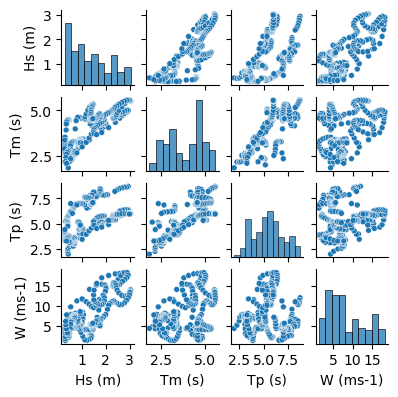

In [5]:
sns.pairplot(data, height=1,plot_kws=dict(size=.1))

In [6]:
data.shape

(299, 4)

We have imported a DataFrame with 4 columns and 299 rows. Each column corresponds to the axle load of one axle in tones.

We will also compute the Cramer-von_mises statistic to compare the empirical copula with the Gaussian, Frank, Gumbel and Clayton copulas and assess whether Gaussian copula is a reasonable hypothesis.

In [7]:
import warnings  
warnings.filterwarnings("ignore")

M = cvm_statistic(data, plot=1, names=data.columns,fig_name='CvM')

AttributeError: module 'numpy' has no attribute 'math'

### 2. Defining the DAG of the NPBN

Here, we will define the following Directed Acyclic Graph (DAG):

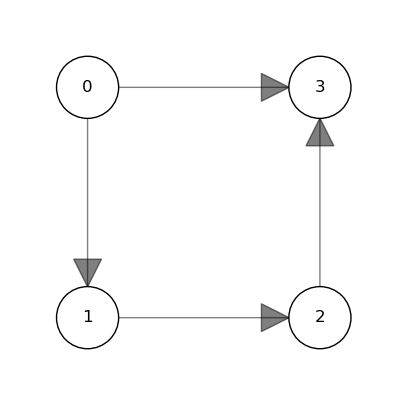

In [8]:
import networkx as nx

G = nx.DiGraph()
G.add_node('0')
G.add_node('1')
G.add_node('2')
G.add_node('3')

# Add edges
G.add_edge('0', '1')
G.add_edge('1', '2')
G.add_edge('0', '3')
G.add_edge('2', '3')

pos = {'0': (0.1, 0.1), '1': (0.1, 0), '2': (0.2, 0), '3': (0.2, 0.1)}

colors = ['white', 'white', 'white', 'white']
sizes = [2000, 2000, 2000, 2000]


# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, edgecolors = 'black')
nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.5, arrows=True, arrowstyle = '-|>', 
                       arrowsize=50, min_source_margin=0.1, min_target_margin=21)  
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.show()

To define the DAG, we follow the next steps:

In [12]:
#Define the number of nodes in the DAG
N = data.shape[1]

#Create a list with length equal to the number of nodes
parents1 = [None]*N  # create an empty list 

#In the created list, we will indicate in the position i the nodes that are parents of i.
#Note that the numbering of the nodes in Python starts in 0
parents1[0] = []     # AW1 does not have parents       
parents1[1] = [0]    # The parent of AW2 is AW1          
parents1[2] = [1]    # The parent of AW3 is AW2     
parents1[3] = [0, 2]    # The parent of AW4 is AW1 and AW3  

#Additionally, we have extracted the names of the variables in the nodes
names = list(data.columns)


Now, we can calculate the rank correlation matrix of the NPBN that we have defined.

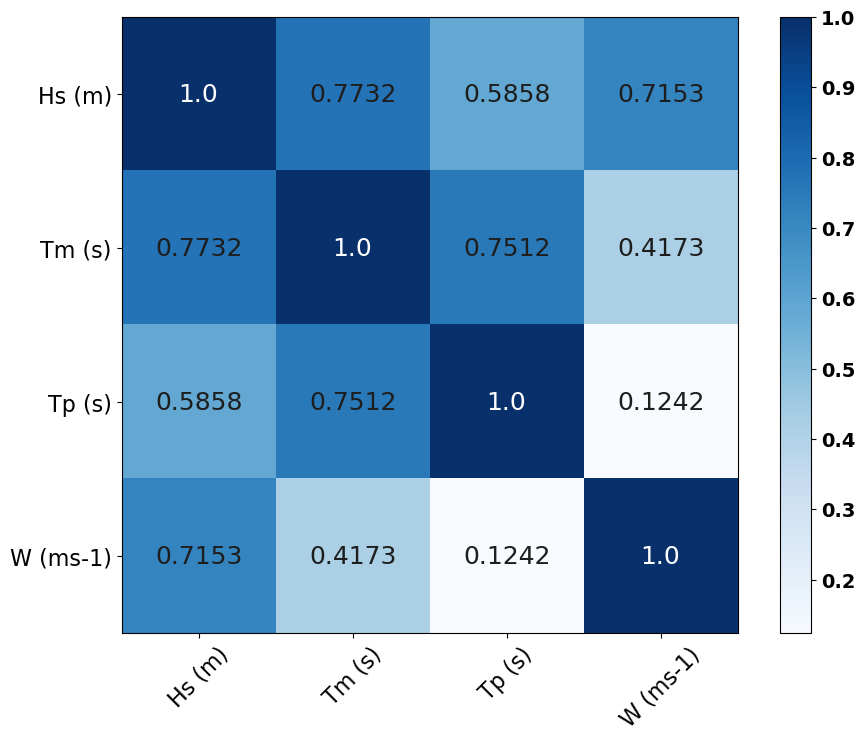

In [13]:
R_BN=bn_rankcorr(parents1,data,var_names=names,is_data=True, plot=True)

In [15]:
!pip install graphviz

And we can also display the graph to check whether the defined DAG is the desired one.

*Note: This cell may give an error due to the package Graphviz. This package is only used for visualization so don't worry. However, if you want to solve the problem locally in your laptop, you can go to the documentation on Brightspace*

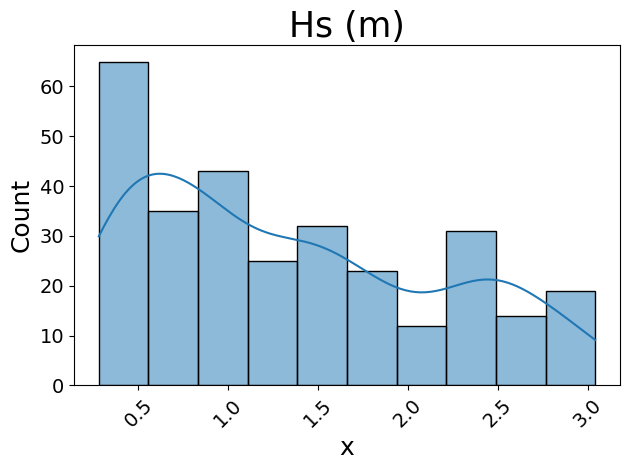

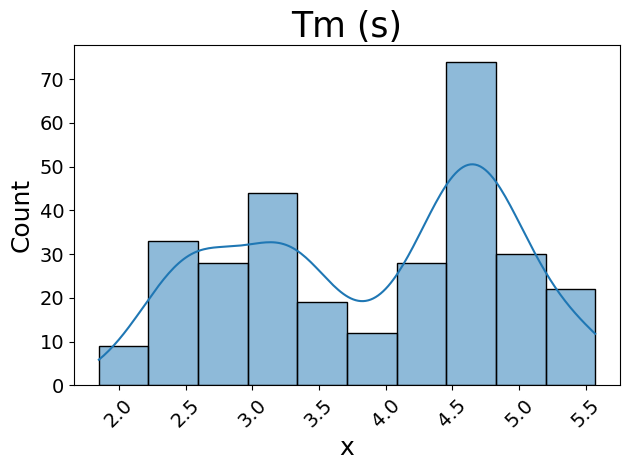

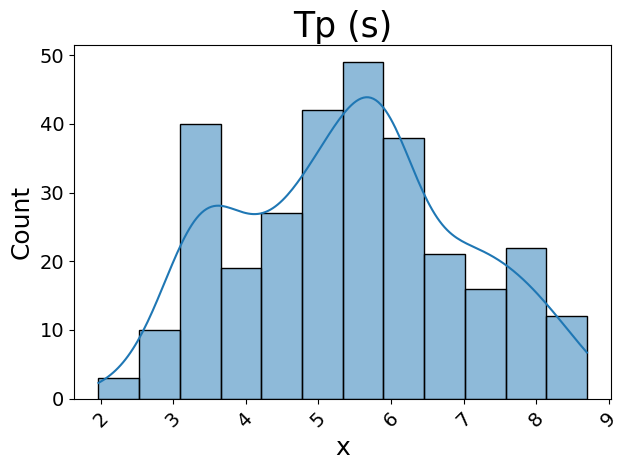

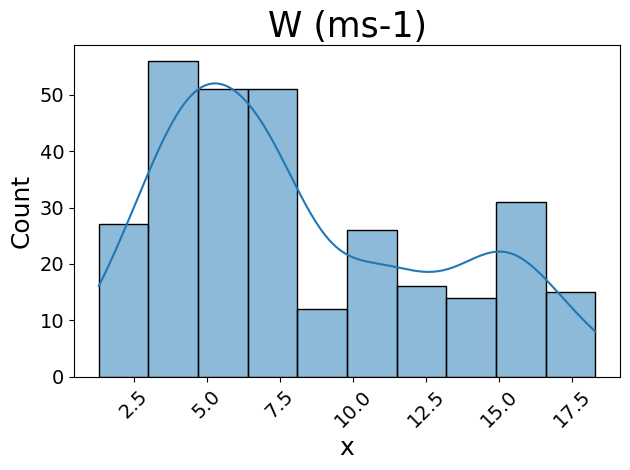

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [16]:
bn_visualize(parents1,                           # structure of the BN
             R_BN,                                 # the rank correlation matrix 
             names,                             # names of variables
             data = data,                       # DataFrame with data
             fig_name =  'NPBN_1')  # figure name


### 3. Assessing the accuracy of the DAG

We can compute the d-calibration score between two rank correlation matrices to compare them. Here we will do it to compare the empirical rank correlation matrix (R_e) and the rank correlation matrix obtained for the BN (R_BN). 

In [ ]:
#Compute the empirical rank correlation matrix using Scipy.stats
R_e = stats.spearmanr(data)[0]

#Compute the d-calibration score
d_cal_E_N = 1 - test_distance(R_e, R_BN, 'H', data.shape[1])
print('The d-calibration score between R_e and R_N is', d_cal_E_N.round(2))

### 4. Using the NPBN

We can use the option 'inference' to conditionalize the joint distribution on a value of one of the random variables. Here we will do it for one variable, but same process can be done for more than one variable at the same time.

In [ ]:
#First we define the nodes in which we want to conditionalize, where we know the value
condition_nodes = [0]

#Then we define the value for the variable
condition_values = [3]

F = inference(Nodes = condition_nodes,
            Values = condition_values,
            R=R_BN, #we provide the rank correlation matrix that defines the joint distribution
            DATA=data, #we provide the dataset
            empirical_data=True, #we use empirical margins, we could also use parametric margins
            SampleSize=1000, #we define the number of conditional samples we want to define the conditional distribution
            Output='full')

Using these samples, we can then plot the conditional and un-conditional marginals.

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,6), layout='constrained')
axes[0].hist(F[0][0], density = True, label = 'Conditional')
axes[0].hist(data.iloc[:,1], density = True, label = 'Unconditional', alpha = 0.5)
axes[0].set_title('Tm (s)',fontsize=18)
axes[0].legend(fontsize=14)

axes[1].hist(F[0][1], density = True, label = 'Conditional')
axes[1].hist(data.iloc[:,2], density = True, label = 'Unconditional', alpha = 0.5)
axes[1].set_title('Tp (s)',fontsize=18)
axes[1].legend(fontsize=14)

axes[2].hist(F[0][2], density = True, label = 'Conditional')
axes[2].hist(data.iloc[:,3], density = True, label = 'Unconditional', alpha = 0.5)
axes[2].set_title('Ws ms-1',fontsize=18)
axes[2].legend(fontsize=14)

End of the tutorial.